In [ ]:
!mkdir /content/processeddata

# **MHealth Dataset**

The MHEALTH (Mobile HEALTH) dataset comprises body motion and vital signs recordings for 10 volunteers of diverse profile while performing several physical activities. Sensors placed on the subject's chest, right wrist and left ankle are used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG. All sensing modalities are recorded at a sampling rate of 50 Hz.


---

Prune to select:
* 3 participants
* Vars: 
  * Column 1: acceleration from the chest sensor (X axis)
  * Column 2: acceleration from the chest sensor (Y axis)
  * Column 3: acceleration from the chest sensor (Z axis)
  * Column 4: electrocardiogram signal (lead 1)
  * Column 5: electrocardiogram signal (lead 2)
  * Column 6: acceleration from the left-ankle sensor (X axis)
  * Column 9: gyro from the left-ankle sensor (X axis)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
!unzip MHEALTHDATASET.zip
from IPython.display import clear_output
clear_output()
import os, torch 
import pandas as pd
import numpy as np
mhealth_dataset = []
for path, dir, file in os.walk("/content/MHEALTHDATASET"):
    for fileNames in file:
        if fileNames.endswith("log"):
            fileName = str(os.path.join(path,fileNames))
            tmpData = pd.read_csv(fileName, sep='\t', engine='python')
            np.shape(tmpData.to_numpy()) # time x variables
            mhealth_dataset.append(tmpData.to_numpy())

We will use participants to represent the "sensors" in the traffic dataset, because the features/variables are collected from all participants.

In [ ]:
tcat = []
for i in range(len(mhealth_dataset)):
  # Truncate all time series to the same length
  t = torch.from_numpy(mhealth_dataset[i][:98303,:])
  tcat.append(t)
tcat = torch.stack(tcat, dim=0)
tcat.size() # subjects x time x var
mhealth = tcat.numpy()
print("Raw 3D time series shape: {0}".format(mhealth.shape))
mhealth_reshaped = np.transpose(mhealth, (1, 0, 2))
print("New 3D time series shape: {0}".format(mhealth_reshaped.shape))

# Downsample the data
mhealth_reshaped_ds = mhealth_reshaped[::5]
print("Downsampled 3D time series shape: {0}".format(mhealth_reshaped_ds.shape))

Raw 3D time series shape: (10, 98303, 24)
New 3D time series shape: (98303, 10, 24)
Downsampled 3D time series shape: (19661, 10, 24)


In [ ]:
# Truncate the dataset
nsubjects = 1
features_to_keep = [1,2,5,6,9]
truncated_mhealth = mhealth_reshaped_ds[:, :nsubjects, features_to_keep]
print("Truncated time series shape: {0}".format(truncated_mhealth.shape)) # timesteps x features

Truncated time series shape: (19661, 1, 5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

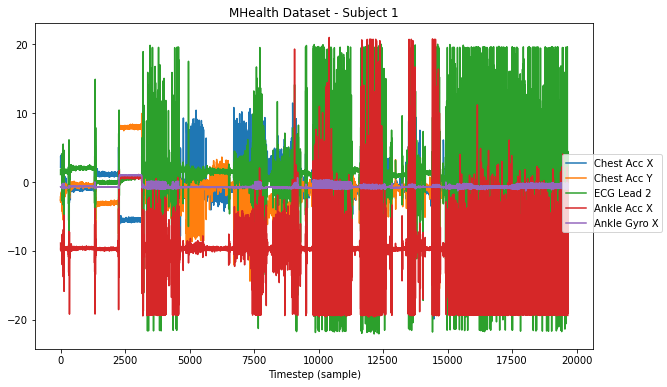

In [ ]:
# Plot
import matplotlib.pyplot as plt
from google.colab import files
legend = ['Chest Acc X', 'Chest Acc Y', 'ECG Lead 2', 'Ankle Acc X', 'Ankle Gyro X']
fig = plt.figure(figsize=(10,6))
for i in range(5):
  plt.plot(truncated_mhealth[:, :, i], label = legend[i])
fig.legend(loc=7)
plt.title('MHealth Dataset - Subject 1')
plt.xlabel('Timestep (sample)')
plt.savefig('mhealth_subject1_traces.png', bbox_inches='tight')
files.download('mhealth_subject1_traces.png') 

## Format MHealth data for STEP

Generates pickle files

In [ ]:
def standard_transform(data: np.array, output_dir: str, name: str, train_index: list, 
                       history_seq_len: int, future_seq_len: int, norm_each_channel: int = False) -> np.array:
    """Standard normalization.
    Args:
        data (np.array): raw time series data.
        output_dir (str): output dir path.
        train_index (list): train index.
        history_seq_len (int): historical sequence length.
        future_seq_len (int): future sequence length.
        norm_each_channel (bool): whether to normalization each channel.
    Returns:
        np.array: normalized raw time series data.
    """

    # data: L, N, C, C=1; time x sensors x features
    data_train = data[:train_index[-1][1], ...]
    if norm_each_channel:
        mean, std = data_train.mean(axis=0, keepdims=True), data_train.std(axis=0, keepdims=True)
    else:
        mean, std = data_train[..., 0].mean(), data_train[..., 0].std()

    print("mean (training data):", mean)
    print("std (training data):", std)
    scaler = {}
    scaler["args"] = {"mean": mean, "std": std}
    # label to identify the scaler for different settings.
    with open(output_dir + "/" + name + "_normed_hist{0}_future{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
        pickle.dump(scaler, f)

    def normalize(x):
        return (x - mean) / std

    data_norm = normalize(data)
    return data_norm

In [ ]:
import os
import sys
import shutil
import pickle
import argparse
import numpy as np
import torch

# Set up parameters
history_seq_len = 50
future_seq_len = 50
train_ratio = 0.6
valid_ratio = 0.2
output_dir = '/content/processeddata'
name = 'truncated_mhealth'

t, n, f = truncated_mhealth.shape
num_samples = t - (history_seq_len + future_seq_len) + 1
train_num_short = round(num_samples * train_ratio)
valid_num_short = round(num_samples * valid_ratio)
test_num_short = round(num_samples * (1 - train_ratio - valid_ratio))
print("number of training samples:{0}".format(train_num_short))
print("number of validation samples:{0}".format(valid_num_short))
print("number of test samples:{0}".format(test_num_short))

# Get indices
index_list = []
for t in range(history_seq_len, num_samples + history_seq_len):
    index = (t-history_seq_len, t, t+future_seq_len)
    index_list.append(index)

train_index = index_list[:train_num_short]
valid_index = index_list[train_num_short: train_num_short + valid_num_short]
test_index = index_list[train_num_short +
                        valid_num_short: train_num_short + valid_num_short + test_num_short]

# Normalize the data
scaler = standard_transform
data_norm = scaler(truncated_mhealth, output_dir, name, train_index, history_seq_len, future_seq_len)
feature_list = [data_norm]
processed_data = np.concatenate(feature_list, axis=-1)
print("Processed series shape: {0}".format(processed_data.shape))

# Write data to pkl file
index = {}
index["train"] = train_index
index["valid"] = valid_index
index["test"] = test_index
with open(output_dir + "/" + name + "_index_hist{0}_future{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(index, f)

data = {}
data["processed_data"] = processed_data
with open(output_dir + "/" + name + "_data_hist{0}_future{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(data, f)

print('')
print('Truncated MHealth data for STEP written to pkl file in output dir (no adj matrix)')

number of training samples:11737
number of validation samples:3912
number of test samples:3912
mean (training data): -0.2348143494400136
std (training data): 2.876554050950841
Processed series shape: (19661, 1, 5)

Truncated MHealth data for STEP written to pkl file in output dir (no adj matrix)


## Format MHealth data for WAVENET

Generates npz files

In [ ]:
import argparse
import numpy as np
import os
import pandas as pd

def generate_graph_seq2seq_io_data(df, x_offsets, y_offsets, scaler=None):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, n, f = df.shape
    data = df
    feature_list = [data]

    data = np.concatenate(feature_list, axis=-1)
    x, y = [], []
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):  # t is the index of the last observation.
        x.append(data[t + x_offsets, ...])
        y.append(data[t + y_offsets, ...])
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y

In [ ]:
# Set up parameters (this should be as similar as the input to STEP as possible)

# *** NOTE: WAVENET NEEDS SYMMETRICAL SEQ LENGTHS! ***

seq_length_x = 50
seq_length_y = 50
y_start = 1
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 1 - train_ratio - valid_ratio
output_dir = '/content/processeddata'
name = 'truncated_mhealth'

df = truncated_mhealth 
x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))
y_offsets = np.sort(np.arange(y_start, (seq_length_y + 1), 1))
x, y = generate_graph_seq2seq_io_data(
    df,
    x_offsets=x_offsets,
    y_offsets=y_offsets
)
print("x shape: ", x.shape, ", y shape: ", y.shape)

# Write the data into npz file.
num_samples = x.shape[0]
num_test = round(num_samples * test_ratio)
num_train = round(num_samples * train_ratio)
num_val = num_samples - num_test - num_train
x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)
x_test, y_test = x[-num_test:], y[-num_test:]

for cat in ["train", "val", "test"]:
    _x, _y = locals()["x_" + cat], locals()["y_" + cat]
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    filename = name + "_" + cat + "_wavenet"
    np.savez_compressed(
        os.path.join(output_dir, f"{filename}.npz"),
        x=_x,
        y=_y,
        x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )

x shape:  (19562, 50, 1, 5) , y shape:  (19562, 50, 1, 5)
train x:  (11737, 50, 1, 5) y: (11737, 50, 1, 5)
val x:  (3913, 50, 1, 5) y: (3913, 50, 1, 5)
test x:  (3912, 50, 1, 5) y: (3912, 50, 1, 5)


# **MotionSense Dataset**

This dataset includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). It is collected with an iPhone 6s kept in the participant's front pocket using SensingKit which collects information from Core Motion framework on iOS devices. All data collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. With this dataset, we aim to look for personal attributes fingerprints in time-series of sensor data, i.e. attribute-specific patterns that can be used to infer gender or personality of the data subjects in addition to their activities.

---
Prune to select:
* 3 participants
* Walk & jog data only
* Vars: acceleration (x,y,z); rotation (x,y,z); gravity (x;y;z)


In [ ]:
%cd /content/
!git clone https://github.com/mmalekzadeh/motion-sense
!unzip /content/motion-sense/data/A_DeviceMotion_data.zip
!unzip /content/motion-sense/data/B_Accelerometer_data.zip
!unzip /content/motion-sense/data/C_Gyroscope_data.zip
clear_output()

In [ ]:
sub_ids = [10]

def get_ds_infos():
    """ Gets inforamtion about data subjects' attributes""" 
    dss = pd.read_csv("/content/motion-sense/data/data_subjects_info.csv")
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """ Select the sensors and the mode to shape the final dataset. """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list

def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=False):
    """ It returns a time-series of sensor data. """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0, num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0, num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in sub_ids:
        for act_id, act in enumerate(act_labels): # for each activity
            for trial in trial_codes[act_id]: # for each variable
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

# Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
# attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration",'gravity','rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS[2:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))  

[INFO] -- Selected sensor data types: ['userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['wlk', 'jog']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(20620, 16)


In [ ]:
dataset

,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,0.100655,-0.207223,0.434824,0.170707,0.967477,-0.186670,-0.610888,-1.417156,-1.486268,0.0,9.0,72.0,164.0,31.0,0.0,7.0
1,-0.257217,0.241457,0.122499,0.140960,0.975569,-0.168504,-1.448704,-0.455702,-1.170750,0.0,9.0,72.0,164.0,31.0,0.0,7.0
2,-0.107223,-0.056170,0.069216,0.130889,0.981875,-0.137072,-1.353352,1.427168,-0.321123,0.0,9.0,72.0,164.0,31.0,0.0,7.0
3,0.071729,-0.137517,0.016593,0.134539,0.984060,-0.116294,-0.566311,1.076465,0.118522,0.0,9.0,72.0,164.0,31.0,0.0,7.0
4,0.185966,-0.206742,0.115382,0.136467,0.984635,-0.108942,-0.331919,-0.294909,0.006548,0.0,9.0,72.0,164.0,31.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20615,0.053884,-0.138966,-0.097085,0.918955,0.321858,0.227852,-0.172824,-1.209841,0.306680,1.0,9.0,72.0,164.0,31.0,0.0,16.0
20616,0.092630,-0.099254,0.020005,0.928046,0.314906,0.198883,-0.660972,-1.645687,0.234395,1.0,9.0,72.0,164.0,31.0,0.0,16.0
20617,0.081522,0.018782,-0.045352,0.932882,0.305208,0.191227,-1.369109,-0.303478,0.324936,1.0,9.0,72.0,164.0,31.0,0.0,16.0
20618,-0.069515,0.170097,-0.053982,0.935924,0.290627,0.198925,-1.062130,0.021990,0.717633,1.0,9.0,72.0,164.0,31.0,0.0,16.0


In [ ]:
truncated_msense = []
features_to_keep = [1,2,3,4,6]
for sub_id in [9]:
  sub_dataset = dataset[dataset["id"].isin([float(sub_id)])]
  sub_tensor = torch.tensor(sub_dataset.values)
  sub_tensor = sub_tensor[0:18836, features_to_keep]
  sub_tensor_numpy = sub_tensor.numpy()
  truncated_msense.append(sub_tensor_numpy)
  
truncated_msense = np.stack(truncated_msense, axis=1)
print("Msense data shape:" + str(truncated_msense.shape)) # timesteps x features


Msense data shape:(18836, 1, 5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

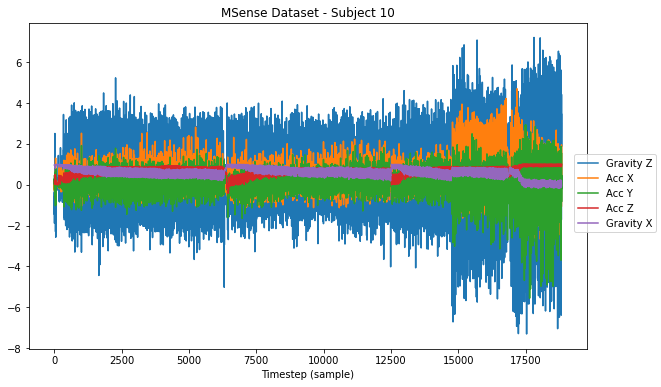

In [ ]:
# Plot
legend = ['Acc X', 'Acc Y', 'Acc Z', 'Gravity X', 'Gravity Z']
fig = plt.figure(figsize=(10,6))
for i in [4, 0, 1, 2, 3]:
  plt.plot(truncated_msense[:, :, i], label = legend[i])
fig.legend(loc=7)
plt.title('MSense Dataset - Subject 10')
plt.xlabel('Timestep (sample)')
plt.savefig('msense_subject10_traces.png', bbox_inches='tight')
files.download('msense_subject10_traces.png') 

## Format MSense data for STEP

In [ ]:
# Set up parameters
history_seq_len = 500
future_seq_len = 50
train_ratio = 0.6
valid_ratio = 0.2
output_dir = '/content/processeddata'
name = 'truncated_msense'

t, n, f = truncated_msense.shape
num_samples = t - (history_seq_len + future_seq_len) + 1
train_num_short = round(num_samples * train_ratio)
valid_num_short = round(num_samples * valid_ratio)
test_num_short = round(num_samples * (1 - train_ratio - valid_ratio))
print("number of training samples:{0}".format(train_num_short))
print("number of validation samples:{0}".format(valid_num_short))
print("number of test samples:{0}".format(test_num_short))

# Get indices
index_list = []
for t in range(history_seq_len, num_samples + history_seq_len):
    index = (t-history_seq_len, t, t+future_seq_len)
    index_list.append(index)

train_index = index_list[:train_num_short]
valid_index = index_list[train_num_short: train_num_short + valid_num_short]
test_index = index_list[train_num_short +
                        valid_num_short: train_num_short + valid_num_short + test_num_short]

# Normalize the data
scaler = standard_transform
data_norm = scaler(truncated_msense, output_dir, name, train_index, history_seq_len, future_seq_len)
feature_list = [data_norm]
processed_data = np.concatenate(feature_list, axis=-1)
print("Processed series shape: {0}".format(processed_data.shape))

# Write data to pkl file
index = {}
index["train"] = train_index
index["valid"] = valid_index
index["test"] = test_index
with open(output_dir + "/" + name + "_index_hist{0}_future{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(index, f)

data = {}
data["processed_data"] = processed_data
with open(output_dir + "/" + name + "_data_hist{0}_future{1}.pkl".format(history_seq_len, future_seq_len), "wb") as f:
    pickle.dump(data, f)

print('')
print('Truncated MSense data for STEP written to pkl file in output dir (no adj matrix)')

number of training samples:10972
number of validation samples:3657
number of test samples:3657
mean (training data): 0.08788398631331183
std (training data): 0.43537602730700253
Processed series shape: (18836, 1, 5)

Truncated MSense data for STEP written to pkl file in output dir (no adj matrix)


## Format MSense data for WAVENET

Generates npz files

In [ ]:
# Set up parameters (this should be as similar as the input to STEP as possible)

# *** NOTE: WAVENET NEEDS SYMMETRICAL SEQ LENGTHS! ***

seq_length_x = 50
seq_length_y = 50
y_start = 1
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 1 - train_ratio - valid_ratio
output_dir = '/content/processeddata'
name = 'truncated_msense'

df = truncated_msense
x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))
y_offsets = np.sort(np.arange(y_start, (seq_length_y + 1), 1))
x, y = generate_graph_seq2seq_io_data(
    df,
    x_offsets=x_offsets,
    y_offsets=y_offsets
)
print("x shape: ", x.shape, ", y shape: ", y.shape)

# Write the data into npz file.
num_samples = x.shape[0]
num_test = round(num_samples * test_ratio)
num_train = round(num_samples * train_ratio)
num_val = num_samples - num_test - num_train
x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)
x_test, y_test = x[-num_test:], y[-num_test:]

for cat in ["train", "val", "test"]:
    _x, _y = locals()["x_" + cat], locals()["y_" + cat]
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    filename = name + "_" + cat + "_wavenet"
    np.savez_compressed(
        os.path.join(output_dir, f"{filename}.npz"),
        x=_x,
        y=_y,
        x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )

x shape:  (18737, 50, 1, 5) , y shape:  (18737, 50, 1, 5)
train x:  (13116, 50, 1, 5) y: (13116, 50, 1, 5)
val x:  (2810, 50, 1, 5) y: (2810, 50, 1, 5)
test x:  (2811, 50, 1, 5) y: (2811, 50, 1, 5)
